# Test

In [1]:
import numpy as np
import pandas as pd
import os,time
import torch
import pickle
import math
import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import ScalarFormatter
import torch.nn.functional as F
sys.path.append('/data/wangchen/instance_centric/instance_centric_model/')
sys.path.append('/data/wangchen/instance_centric/')
from parser_args import get_parser
from src.model import Model
from matplotlib.ticker import FuncFormatter


## function

### handle batch

In [2]:
def prepare_batch(batch_list):
    batch_size = len(batch_list)
    key_to_list = {}
    for key in batch_list[0].keys():
        key_to_list[key] = [batch_list[bs_idx][key] for bs_idx in range(batch_size)]

    input_dict = {}
    for key, val_list in key_to_list.items():
        val_list = [torch.from_numpy(x) for x in val_list]
        if key in ['agent_feats', 'agent_mask', 'agent_ctrs', 'agent_vecs', 'gt_preds',
                    'plan_feat', 'plan_mask', 'map_ctrs', 'map_vecs', 'map_feats', 'map_mask','gt_vel_mode', 'ego_gt_cand', 'ego_refpath_cords', 'ego_refpath_vecs', 'ego_cand_mask']:
            input_dict[key] = merge_batch_1d(val_list).to('cuda')
        elif key in ['candidate_mask', 'gt_candts', 'rpe', 'rpe_mask']:
            input_dict[key] = merge_batch_2d(val_list).to('cuda')
        elif key in ['candidate_refpaths_cords', 'candidate_refpaths_vecs']:
            input_dict[key] = merge_batch_2d_more(val_list).to('cuda')
        elif key in ['ego_vel_mode', "ego_gt_traj"]:
            input_dict[key] = torch.stack(val_list,dim=0) #(B,)
        else:
            print(key)
            continue
    return input_dict

def merge_batch_1d(tensor_list):# agent feats:list[all_n,20,13]      agent mask: list[all_n,20]
    assert len(tensor_list[0].shape) in [1,2, 3]
    only_2d_tensor = False
    if len(tensor_list[0].shape) == 2:
        tensor_list = [x.unsqueeze(dim=-1) for x in tensor_list] # [alln,20] -> [alln,20,1]      [bs,alln,20,1]
        only_2d_tensor = True

    only_1d_tensor = False
    if len(tensor_list[0].shape) == 1:
        tensor_list = [x.unsqueeze(dim=-1).unsqueeze(dim=-1) for x in tensor_list] 
        only_1d_tensor = True

    tensor_list = [x.unsqueeze(dim=0) for x in tensor_list] #list[1, all_n,20,13]
    max_feat0 = max([x.shape[1] for x in tensor_list]) # all_n-Max
    _, _, num_feat1, num_feat2 = tensor_list[0].shape # [20,13]
    ret_tensor_list = []
    for k in range(len(tensor_list)):
        cur_tensor = tensor_list[k] # [1, all_n,20,13]
        assert cur_tensor.shape[2] == num_feat1 and cur_tensor.shape[3] == num_feat2

        new_tensor = cur_tensor.new_zeros(cur_tensor.shape[0], max_feat0, num_feat1, num_feat2) # [1, all_n-Max,20,13]
        new_tensor[:, :cur_tensor.shape[1], :, :] = cur_tensor # [1, all_n-Max,20,13]
        ret_tensor_list.append(new_tensor) # list[1, all_n-Max,20,13]

    ret_tensor = torch.cat(ret_tensor_list, dim=0)  # [bs, all_n-Max,20,13]
    if only_2d_tensor:
        ret_tensor = ret_tensor.squeeze(dim=-1)
    if only_1d_tensor:
        ret_tensor = ret_tensor.squeeze(dim=-1).squeeze(dim=-1)
    return ret_tensor

def merge_batch_2d(tensor_list):
    assert len(tensor_list[0].shape) in [2, 3]
    only_2d_tensor = False
    if len(tensor_list[0].shape) == 2:
        tensor_list = [x.unsqueeze(dim=-1) for x in tensor_list]
        only_2d_tensor = True
    tensor_list = [x.unsqueeze(dim=0) for x in tensor_list]
    max_feat0 = max([x.shape[1] for x in tensor_list])
    max_feat1 = max([x.shape[2] for x in tensor_list])

    num_feat2 = tensor_list[0].shape[-1]
    ret_tensor_list = []
    for k in range(len(tensor_list)):
        cur_tensor = tensor_list[k]
        new_tensor = cur_tensor.new_zeros(cur_tensor.shape[0], max_feat0, max_feat1, num_feat2)
        new_tensor[:, :cur_tensor.shape[1], :cur_tensor.shape[2], :] = cur_tensor
        ret_tensor_list.append(new_tensor)

    ret_tensor = torch.cat(ret_tensor_list, dim=0)  # (num_stacked_samples, num_feat0_maxt, num_feat1_maxt, num_feat2)
    if only_2d_tensor:
        ret_tensor = ret_tensor.squeeze(dim=-1)
    return ret_tensor

def merge_batch_2d_more( tensor_list):
    assert len(tensor_list[0].shape) == 4
    tensor_list = [x.unsqueeze(dim=0) for x in tensor_list] # list[1, all_n, Max-N, 20, 2]
    max_feat0 = max([x.shape[1] for x in tensor_list]) # all_n-Max
    max_feat1 = max([x.shape[2] for x in tensor_list]) # Max-N-Max
    num_feat2 = tensor_list[0].shape[3] # 20
    num_feat3 = tensor_list[0].shape[4] # 2
    ret_tensor_list = []

    for k in range(len(tensor_list)):
        cur_tensor = tensor_list[k]
        new_tensor = cur_tensor.new_zeros(cur_tensor.shape[0], max_feat0, max_feat1, num_feat2, num_feat3) # 1, all_n-Max, Max-N-Max, 2
        new_tensor[:, :cur_tensor.shape[1], :cur_tensor.shape[2], :, :] = cur_tensor
        ret_tensor_list.append(new_tensor)

    ret_tensor = torch.cat(ret_tensor_list, dim=0)  # bs,all_n-Max, Max-N-Max, 20, 2
    return ret_tensor


### plot 

#### plot method

In [3]:
def simple_formatter(x, pos):
    return f'{x:.0f}'

def transform_to_ori(feat, ctr, vec):    
    if not isinstance(feat, np.ndarray):
        feat = feat.detach().cpu().numpy()
    if not isinstance(ctr, np.ndarray):
        ctr = ctr.detach().cpu().numpy()
    if not isinstance(vec, np.ndarray):
        vec = vec.detach().cpu().numpy()
    cos_, sin_ = vec
    rot = np.asarray([[sin_, cos_], [-cos_, sin_]])
    rot_inv = rot.T
    feat[:, 0:2] = np.matmul(feat[:, 0:2], rot_inv) + ctr
    return feat

def calculate_box_corners(x, y, yaw, length, width):
    x += length*0.295*math.cos(yaw)
    y += length*0.295*math.sin(yaw)
    half_length = length/2
    half_width = width/2
    corner_xs, corner_ys = [], []
    # right head
    corner_xs.append(x + half_length * math.cos(yaw) + half_width * math.cos(yaw - 0.5*math.pi))
    corner_ys.append(y + half_length * math.sin(yaw) + half_width * math.sin(yaw - 0.5*math.pi))
    # left head
    corner_xs.append(x + half_length * math.cos(yaw) + half_width * math.cos(yaw + 0.5*math.pi))
    corner_ys.append(y + half_length * math.sin(yaw) + half_width * math.sin(yaw + 0.5*math.pi))
    # left tail
    corner_xs.append(x + half_length * math.cos(yaw + math.pi) + half_width * math.cos(yaw + 0.5*math.pi))
    corner_ys.append(y + half_length * math.sin(yaw + math.pi) + half_width * math.sin(yaw + 0.5*math.pi))
    # right tail
    corner_xs.append(x + half_length * math.cos(yaw + math.pi) + half_width * math.cos(yaw - 0.5*math.pi))
    corner_ys.append(y + half_length * math.sin(yaw + math.pi) + half_width * math.sin(yaw - 0.5*math.pi))

    corner_xs.append(corner_xs[0])
    corner_ys.append(corner_ys[0])
    return corner_xs, corner_ys

def select_top_n(ax, pred_trajs, candidate_refpaths,cand_refpath_probs, pred_probs, top_n=1):# M,50，2 +  M,20,2,  + M
    '''
    用于选出前几个的轨迹，返回轨迹、轨迹信息、也即对应的refpath
    '''
    
    valid_pred_probs_len = (pred_probs > 0.001).sum() # 得到有效的prob个数
    top_n = min(top_n, valid_pred_probs_len)
    max_scores_indices = pred_probs.argsort()[::-1][:top_n] # S，     获取prob排名前S个的idx
    
    scores = pred_probs[max_scores_indices]# S
    max_pred_trajs = pred_trajs[max_scores_indices,:, :] # S,50,2
    max_pred_refpath = candidate_refpaths[max_scores_indices,:,:] # S, 20, 2
    max_pred_repath_probs = cand_refpath_probs[max_scores_indices]
    
    # score_sum = sum(scores)# top n的概率进行重分配
    # acc_prob = 0 # 用作终止条件
    # prob_info = ''
    # traj_index = 0
    # while traj_index < max_pred_trajs.shape[0]:# 对前S个进行概率
    #     prob = scores[traj_index]
    #     prob_info += f'traj_{traj_index}:{str(round(prob/score_sum, 3))}, '
    #     traj_index += 1
    #     acc_prob += prob/score_sum
    #     if acc_prob > 0.75:
    #         break
    prob_info = ''
    for i in range(top_n):
        prob_info += f"traj_{i}'s prob={str(round(scores[i], 2))}, "
        
    # return max_pred_trajs[:traj_index], prob_info # s,50,2
    return max_pred_trajs, max_pred_refpath, max_pred_repath_probs, prob_info # s,50,2

def plot_one_cand_refpath_and_correspond_3_pred_trajs(ax, agent_ctr, agent_vec, pred_trajs, candidate_refpaths_cords, candidate_mask, all_candidate_mask):
    # 3M,50,2     M,20,2        M    3M
    idx = np.nonzero(candidate_mask==1)[0]
    print("idx",idx)


    refpath_cords = transform_to_ori(candidate_refpaths_cords[idx], agent_ctr, agent_vec)
    ax.plot(refpath_cords[:,0], refpath_cords[:, 1], color = "red", linewidth = 0.7, alpha= 0.8) # 对应的候选ref path


    for i in range(3):
        traj_idx = idx*3 + i
        pred_traj = transform_to_ori(pred_trajs[traj_idx], agent_ctr, agent_vec)
        if i ==0:
            color = "blue"
            text_str="acc"
        elif i == 1:
            color = "purple"
            text_str="constant"
        else:
            color = "green"
            text_str="delc"
        ax.plot(pred_traj[:, 0], pred_traj[:, 1], color = color, linewidth = 1.0, alpha= 0.8) # 对应的候选ref path
        ax.scatter(pred_traj[-1,0], pred_traj[-1,1],color=color,s=7)
        ax.text(pred_traj[-1,0], pred_traj[-1,1], text_str, color = color, fontsize=8)

        
        
def draw_refpath(ax,refpath_cords,transform, color, marker=',', prob=0.0,text=''):
    refpath_cords = transform_to_ori(refpath_cords, transform[0],transform[1])
    ax.plot(refpath_cords[:,0], refpath_cords[:,1], color = color, linewidth=0.8)
    
    # text    
    all_str = []
    if text != "":
        all_str.append(text)
    if prob != 0.0:
        all_str.append(f"--{str(round(prob,3))}")
    ax.text(refpath_cords[-1,0], refpath_cords[-1, 1], ", ".join(all_str),fontsize=5)


def draw_traj(ax, traj, transform, color, marker = ',', prob=0.0, text='',score=0.0):
    traj = transform_to_ori(traj, transform[0], transform[1])
    ax.plot(traj[:,0], traj[:,1], color= color, linewidth=0.8)
    ax.scatter(traj[-1,0], traj[-1,1], color= color, s=8) # draw end point
    
    
    # text
    all_str = []
    if text != "":
        all_str.append(text)
    if prob != 0.0:
        all_str.append("pb:" + str(round(prob,3)))
    if score != 0.0:
        all_str.append("sr:" + str(round(score,3)))
    ax.text(traj[-1,0], traj[-1,1], ", ".join(all_str),color=color,fontsize=5)



#### plot main

In [47]:
def plot_case(input_dict, output_dict, save_path=None):
    # 仅取batch中的一个sample
    # input 
    agent_feats = input_dict['agent_feats'][0]# all_n, 20, 13
    agent_mask = input_dict['agent_mask'][0] # all_n, 20
    agent_ctrs = input_dict['agent_ctrs'][0] # all_n, 2
    agent_vecs = input_dict['agent_vecs'][0] # all_n, 2
    map_feats = input_dict['map_feats'][0]# men, 20, 5
    map_mask = input_dict['map_mask'][0]# men, 20
    map_ctrs = input_dict['map_ctrs'][0]
    map_vecs = input_dict['map_vecs'][0]
    
    
    # agent
    agent_gt_trajs = input_dict['gt_preds'][0].detach().cpu().numpy() # all_n, 50, 2 未来真值轨迹
    agent_candidate_refpath_cords = input_dict['candidate_refpaths_cords'][0].detach().cpu().numpy() # all_n, M, 20, 2 候选path
    agent_candidate_mask = input_dict['candidate_mask'][0].detach().cpu().numpy() # all_n, M     候选path mask
    agent_candidate_mask_idx = agent_candidate_mask.sum(axis=-1) > 0 # all_n  是否存在候选 path
    agent_gt_candt_refpath = input_dict['gt_candts'][0].detach().cpu().numpy()# all_n, M    候选path真值
    agent_gt_candt_idx = np.argmax(agent_gt_candt_refpath, axis= 1) # all_n
    
    agent_pred_cand_refpath_probs = output_dict['cand_refpath_probs'][0].detach().cpu().numpy() # all_n, M
    agent_pred_trajs = output_dict['trajs'][0].detach().cpu().numpy() # all_n,3M,50,2
    agent_pred_traj_with_gt = output_dict['traj_with_gt'][0].detach().cpu().numpy() # all_n,1,50,2
    agent_pred_traj_probs = output_dict['traj_probs'][0].detach().cpu().numpy() # all_n, 3M
    # all_candidate_mask = output_dict['all_candidate_mask'][0].detach().cpu().numpy() # all_n, 3M
    

   
    # ego
    ego_gt_trajs = input_dict['ego_gt_traj'][0].detach().cpu().numpy() # 50,2
    ego_candidate_refpath_cords = input_dict['ego_refpath_cords'][0].detach().cpu().numpy() # M,20,2
    ego_candidate_mask = input_dict['ego_cand_mask'][0].detach().cpu().numpy() # M
    ego_gt_candt_refppath = input_dict['ego_gt_cand'][0].detach().cpu().numpy() # M
    ego_gt_candt_idx = np.argmax(agent_gt_candt_refpath, axis= -1) # all_n

    ego_pred_cand_refpath_probs = output_dict['plan_cand_refpath_probs'][0].detach().cpu().numpy() # M
    ego_pred_trajs = output_dict['plan_trajs'][0].detach().cpu().numpy() #3M,50,2
    ego_pred_traj_with_gt = output_dict['plan_traj_with_gt'][0].detach().cpu().numpy() # 50,2
    ego_pred_traj_probs = output_dict['plan_traj_probs'][0].detach().cpu().numpy() # 3M
    
    
    scores = np.zeros_like(ego_pred_traj_probs) # 3M
    if output_dict['scores'] != None:
        # def score_to_prob(scores):
        #     probs = torch.from_numpy(scores)
        #     probs = probs - probs.min(-1).values
        #     return F.softmax(probs).numpy()
        scores = output_dict['scores'][0].detach().cpu().numpy() #3M
        # scores = score_to_prob(scores)
    
    

    fig, ax = plt.subplots(figsize=(18,12))
    ax.axis("equal")
    ax.xaxis.set_major_formatter(FuncFormatter(simple_formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(simple_formatter))
    min_width, min_height = 1e8, 1e8
    max_width, max_height = -1, -1

            
        
        
        
    
    for i in range(map_feats.shape[0]): # 画出周围地图信息
        line_info = transform_to_ori(map_feats[i][map_mask[i].bool()], map_ctrs[i], map_vecs[i])# 20,5 + 2 + 2
        ax.plot(line_info[:, 0], line_info[:, 1], color='y', linewidth=0.5)
        min_width = min(min(line_info[:, 0]), min_width)
        max_width = max(max(line_info[:, 0]), max_width)
        min_height = min(min(line_info[:, 1]), min_height)
        max_height = max(max(line_info[:, 1]), max_height)

    
    for i in range(agent_candidate_mask_idx.shape[0]): # 画出每一个障碍物信息
        traj_info = transform_to_ori(agent_feats[i][agent_mask[i].bool()], agent_ctrs[i], agent_vecs[i])# 得到agent的信息 （20,13） mask-> (s,13)
        min_width = min(min(traj_info[:, 0]), min_width)
        max_width = max(max(traj_info[:, 0]), max_width)
        min_height = min(min(traj_info[:, 1]), min_height)
        max_height = max(max(traj_info[:, 1]), max_height)
        ax.plot(traj_info[:, 0], traj_info[:, 1], color='tan', linewidth=1.0)# 该agent所有历史轨迹画棕色
        
        
        marker = '.'
        color = 'g'
        if agent_candidate_mask_idx[i]:# 该agent是目标障碍物
            transform = (agent_ctrs[i], agent_vecs[i])
            
            
            ########################################################################
            ########################################################################
            # mode 1
            # 画出 ref path
            # 画出 ref path对应的traj
#             valid_candidate = np.nonzero(candidate_mask[i]==1)[0] # S
#             colors = plt.cm.viridis(np.linspace(0, 0.8, valid_candidate.shape[0]))
#             for idx,(cand,c) in enumerate(zip(valid_candidate,colors)):
#                 # if idx ==2:
                    
#                 draw_refpath(ax, candidate_refpaths_cords[i][cand], transform, color=c,prob=cand_refpath_probs[i][cand], text="ref"+str(cand))
#                 draw_traj(ax, pred_trajs[i][cand*3], transform, color=c,prob=pred_probs[i][cand*3], text=f"{cand}_acc")
#                 draw_traj(ax, pred_trajs[i][cand*3 + 1], transform, color=c,prob=pred_probs[i][cand*3+1], text=f"{cand}_const")
#                 draw_traj(ax, pred_trajs[i][cand*3 + 2], transform, color=c,prob=pred_probs[i][cand*3+2], text=f"{cand}_dec")
            

            ########################################################################
            ########################################################################
            # # mode 2
            # # 按照概率 画出traj 的top n，并画出对应的ref path
#             top_n = 5
#             sort_idces = np.argsort(agent_pred_traj_probs[i])[::-1][:top_n] # 3M
#             ref_dict = {}
#             for traj_idx in sort_idces:
#                 ref_idx = traj_idx//3
#                 if ref_idx not in ref_dict.keys():
#                     ref_dict[ref_idx] = [traj_idx]
#                 else:
#                     ref_dict[ref_idx].append(traj_idx)
            
#             colors = plt.cm.viridis(np.linspace(0, 0.8, len(ref_dict)))
#             for ref_idx, c in zip(ref_dict.keys(), colors):
#                 draw_refpath(ax, agent_candidate_refpath_cords[i][ref_idx], transform, color=c,prob=agent_pred_cand_refpath_probs[i][ref_idx], text="ref"+str(ref_idx))
#                 traj_idxes = ref_dict[ref_idx]
                
#                 for traj_idx in traj_idxes:
#                     traj_text = str(ref_idx)
#                     if traj_idx % 3 == 0:
#                         traj_text += "acc"
#                     elif traj_idx % 3 == 1:
#                         traj_text += "const"
#                     else:
#                         traj_text += "dec"
#                     draw_traj(ax, agent_pred_trajs[i][traj_idx], transform, color=c, prob=agent_pred_traj_probs[i][traj_idx], text = traj_text)
            
            

        elif i==0:
            # EGO
            color = 'r' 
            transform = (agent_ctrs[i], agent_vecs[i])


            # # mode 2
            # # 按照概率 画出traj 的top n，并画出对应的ref path
            top_n = 4
            sort_idces = np.argsort(ego_pred_traj_probs)[::-1][:top_n] # 3M
            ref_dict = {}
            for traj_idx in sort_idces:
                ref_idx = traj_idx//3
                if ref_idx not in ref_dict.keys():
                    ref_dict[ref_idx] = [traj_idx]
                else:
                    ref_dict[ref_idx].append(traj_idx)
            
            colors = plt.cm.viridis(np.linspace(0, 0.8, len(ref_dict)))
            for ref_idx, c in zip(ref_dict.keys(), colors):
                draw_refpath(ax, ego_candidate_refpath_cords[ref_idx], transform, color=c,prob=ego_pred_cand_refpath_probs[ref_idx], text="ref"+str(ref_idx))
                traj_idxes = ref_dict[ref_idx]
                
                for traj_idx in traj_idxes:
                    traj_text = str(ref_idx)
                    if traj_idx % 3 == 0:
                        traj_text += "acc"
                    elif traj_idx % 3 == 1:
                        traj_text += "const"
                    else:
                        traj_text += "dec"
                    draw_traj(ax, ego_pred_trajs[traj_idx], transform, color=c, score=scores[traj_idx], prob=ego_pred_traj_probs[traj_idx], text = traj_text)
            







            # draw_traj(ax, ego_plan_trajs[0], transform, color='red', text=f"acc",score=scores[0])
            # draw_traj(ax, ego_plan_trajs[1], transform, color='red', text=f"const", score=scores[1])
            # draw_traj(ax, ego_plan_trajs[2], transform, color='red', text=f"dec", score=scores[2])
            # draw_refpath(ax, ego_candidate_refpath_cords, transform, color="blue",text="rf")
            draw_traj(ax, ego_gt_trajs, transform, color="green", text="gt")
            
            
        ax.plot(traj_info[-1, 0], traj_info[-1, 1], marker=marker, markersize=8, color=color) # 画出观测点
        length, width = traj_info[-1, 4], traj_info[-1, 5]
        theta = math.atan2(agent_vecs[i][1], agent_vecs[i][0])
        # 画出车头    自车用红色,target agent用蓝色，无关车用绿色
        corner_xs, corner_ys = calculate_box_corners(traj_info[-1, 0], traj_info[-1, 1], theta, length, width)
        ax.plot(corner_xs, corner_ys, color=color, linewidth=1.0)
        ax.text(corner_xs[0]+0.5,corner_ys[0]+0.5,f"agent-{i}", color=color)
        
    roi_matrix = [min_width, max_width, min_height, max_height]
    ax.axis(roi_matrix) 
    if save_path is None:
        plt.show()
    else:
        save_path = os.path.join(save_path, time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(time.time())) + ".jpg")
        print(f"fig save at {save_path}")
        plt.savefig(save_path, dpi=300)
        plt.close()
    return

### secondary

In [5]:
def get_model_output(index):
    pickle_path = input_dir + file_names[index]
    print("pickle_path:",pickle_path)
    with open(pickle_path, 'rb') as f:
        data_dict = pickle.load(f) # pickle read numpy data
    input_dict = prepare_batch([data_dict]) # numpy to tensor
    
    print("=="*100)
    print(input_dict['agent_ctrs'].device)
    print(model.device)
    output_dict = model(input_dict)
    return input_dict, output_dict

## main

In [7]:
# 加载模型
part = "all"
model_path = '/private/wangchen/instance_model/output/MODEL/2024-06-28 17:13:02_back/saved_models/MODEL_epoch_025.pt'
parser = get_parser()
args = parser.parse_args([])
if part == "all":
    args.train_part = "back"
    model = Model(args).cuda(0)
    from src.layers.score_decoder import ScoreDecoder
    model.scorer = ScoreDecoder(n_order=7).cuda()
else:
    args.train_part = "front"
    model = Model(args).cuda(0)
    
device = torch.device('cuda:0')
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
input_dir = '/private/wangchen/instance_model/instance_model_data_new_version/test/'
file_names = os.listdir(input_dir)
print("file num:", len(file_names))
output_dir = '/data/wangchen/plot_instance/'
os.makedirs(output_dir, exist_ok=True)

file num: 67348


In [67]:
index = 35

    # for i in range(len(data['inter_info'])):
        
    # for i in range(len(data['inter_info'])):
        
    # for i in range(len(data['inter_info'])):
        
    # for i in range(len(data['inter_info'])):
    
        
    # for i in range(len(data['inter_info'])):
        
input_dict, output_dict = get_model_output(index)
plot_case(input_dict, output_dict, save_path="./")
# plot_case(input_dict, output_dict)

pickle_path: /private/wangchen/instance_model/instance_model_data_new_version/test/howo27_1680232755.2020001.pkl
cuda:0
cuda
fig save at ./2024-06-29 10:36:01.jpg


# test transofrm

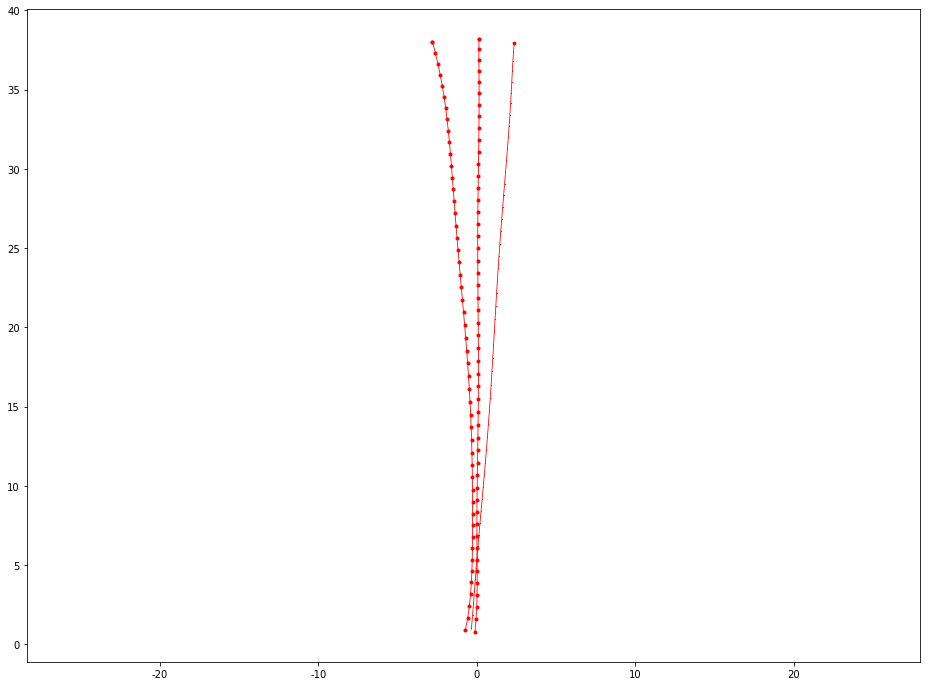

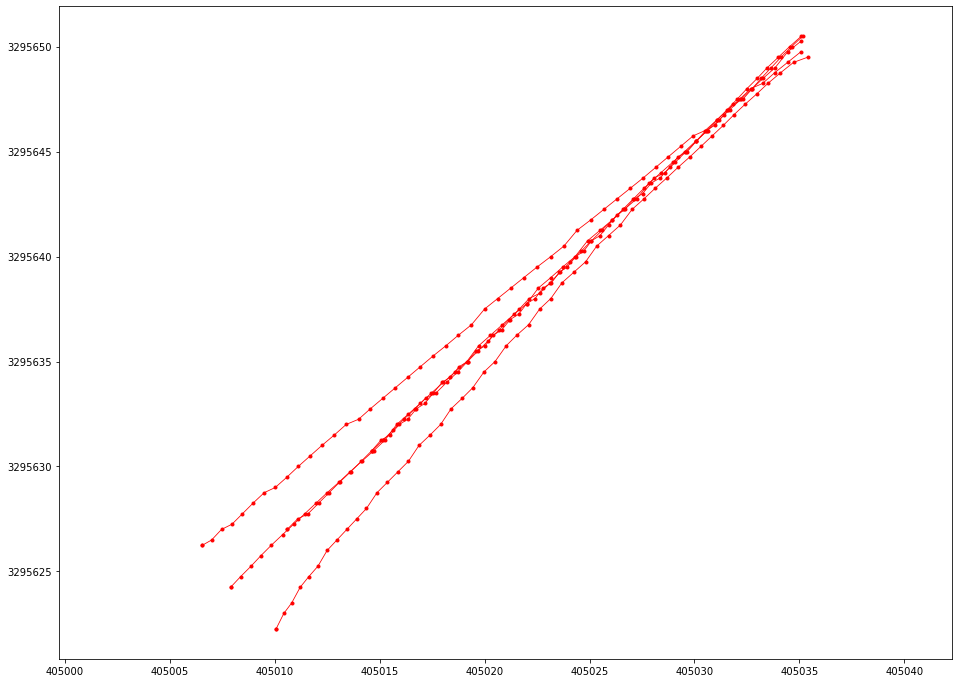

In [109]:
def get_transform(agent_vecs):
    # B,N,2
    # B,N,2,2
    B, N, _ = agent_vecs.shape
    cos_, sin_ = agent_vecs[:,:,0], agent_vecs[:,:,1] # B,N
    rot_matrix = torch.zeros(B, N, 2, 2, device=agent_vecs.device)
    rot_matrix[:,:,0,0] = sin_
    rot_matrix[:,:,0,1] = cos_
    rot_matrix[:,:,1,0] = -cos_
    rot_matrix[:,:,1,1] = sin_
    # one = torch.cat([sin_,cos_], dim=-1).unsqueeze(-2) # B,N,1,2
    # two = torch.cat([-cos_, sin_], dim= -1).unsqueeze(-2) # B,N,1,2
    return rot_matrix


def transform_to_ori(feat, transforms, ctrs):
    '''
    feat: B,N,M,50,2
    transforms: B,N,2,2
    ctrs: B,N,2
    '''
    squeeze_flag = False
    if len(feat.shape) == 4:
        squeeze_flag = True
        feat = feat.unsqueeze(1) # B,1,3,50,2
        transforms = transforms.unsqueeze(1) # B,1,2,2
        ctrs = ctrs.unsqueeze(1) # B,1,2
    # B,N,M,50,2
    rot_inv = transforms.transpose(-2, -1) 
    feat[..., 0:2] = torch.matmul(feat[..., 0:2], rot_inv[:,:,None,:,:]) + ctrs[:,:,None,None,:] # B,N,M,50,2@B,N,1,2,2 + B,N,1,1,2
    if squeeze_flag:
        feat = feat.squeeze(1)
    return feat

def draw_traj(ax, traj, color, marker = ',', prob=0.0, text='',score=0.0):
    ax.plot(traj[:,0], traj[:,1], color= color,marker=marker, linewidth=0.8)
    ax.scatter(traj[-1,0], traj[-1,1], color= color, s=8) # draw end point
    
    
    # text
    all_str = []
    if text != "":
        all_str.append(text)
    if prob != 0.0:
        all_str.append(str(round(prob,3)))
    if prob != 0.0:
        all_str.append(str(round(score,3)))
    ax.text(traj[-1,0], traj[-1,1], ", ".join(all_str),color=color,fontsize=5)

def simple_formatter(x, pos):
    return f'{x:.0f}'

fig, ax = plt.subplots(figsize=(16,12))
ax.axis("equal")
ax.xaxis.set_major_formatter(FuncFormatter(simple_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(simple_formatter))


trajs= output_dict['trajs'].detach().cpu().numpy() # B,N,3M,50,2
tj = trajs[0,1] # 3M,50,2
draw_traj(ax, tj[0],'red',marker='.') 
draw_traj(ax, tj[3],'red',marker='.') 
draw_traj(ax, tj[6],'red') 
 

agent_ctrs = input_dict['agent_ctrs'] # B,all_n, 2 
agent_vecs = input_dict['agent_vecs'] # B,all_n, 2


fig2, ax2 = plt.subplots(figsize=(16,12))
ax2.axis("equal")
ax2.xaxis.set_major_formatter(FuncFormatter(simple_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(simple_formatter))


transforms = get_transform(agent_vecs)
tf_trajs = transform_to_ori(torch.from_numpy(trajs).to('cuda'), transforms, agent_ctrs)
tf_trajs = tf_trajs.detach().cpu().numpy()
tf_tj = tf_trajs[0,1] # 3M,50,2
draw_traj(ax2, tf_tj[0],'red',marker='.')
draw_traj(ax2, tf_tj[1],'red',marker='.')
draw_traj(ax2, tf_tj[2],'red',marker='.')
draw_traj(ax2, tf_tj[3],'red',marker='.')
draw_traj(ax2, tf_tj[6],'red',marker='.')
# draw_traj(ax2, tf_trajs[0,2,0],'red',marker='.')
# draw_traj(ax2, tf_trajs[0,3,0],'red',marker='.')
# draw_traj(ax2, tf_trajs[0,4,0],'red',marker='.')
# draw_traj(ax2, tf_trajs[0,5,0],'red',marker='.')
# draw_traj(ax2, tf_trajs[0,6,0],'red',marker='.')

# draw_traj(ax2, tf_tj[1],'red', marker='.')
# draw_traj(ax2, tf_tj[2],'red')
# draw_traj(ax2, tf_tj[3],'red')





In [ ]:
agent_feats = input_dict['agent_feats'][0]
agent_mask = input_dict['agent_mask'][0]
agent_ctrs = input_dict['agent_ctrs'][0]
agent_vecs = input_dict['agent_vecs'][0]
map_feats = input_dict['map_feats'][0]
map_mask = input_dict['map_mask'][0]
map_ctrs = input_dict['map_ctrs'][0]
map_vecs = input_dict['map_vecs'][0]
agent_gt_trajs = input_dict['gt_preds'][0]
agent_pred_trajs = output_dict['trajs'][0].detach().cpu().numpy()
agent_pred_traj_probs = output_dict['traj_probs'][0].detach().cpu().numpy()
agent_candidate_mask = input_dict['candidate_mask'][0]
pred_mask = agent_candidate_mask.sum(dim=-1) > 0

In [44]:
agent_feats[1][:, 2]

tensor([5.8876, 5.9458, 5.9822, 5.8937, 5.8319, 5.7639, 5.7466, 5.7410, 5.6962,
        5.7130, 5.7250, 5.7651, 5.7436, 5.6762, 5.4997, 5.3394, 5.1951, 5.0529,
        4.9126, 4.8075], device='cuda:0')

In [45]:
agent_mask[1]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0', dtype=torch.int32)

In [54]:
agent_feats = input_dict['agent_feats'][0]# all_n, 20, 13
agent_mask = input_dict['agent_mask'][0] # all_n, 20
agent_ctrs = input_dict['agent_ctrs'][0] # all_n, 2
agent_vecs = input_dict['agent_vecs'][0] # all_n, 2

map_feats = input_dict['map_feats'][0]# men, 20, 5
map_mask = input_dict['map_mask'][0]# men, 20
map_ctrs = input_dict['map_ctrs'][0]
map_vecs = input_dict['map_vecs'][0]

agent_gt_trajs = input_dict['gt_preds'][0] # all_n, 50, 2
agent_candidate_refpath_cords = input_dict['candidate_refpaths_cords'][0].detach().cpu().numpy() # all_n, M, 20, 2

agent_gt_candt_refpath = input_dict['gt_candts'][0].detach().cpu().numpy()# all_n, M
agent_gt_candt_idx = np.argmax(agent_gt_candt_refpath, axis= 1) # all_n


agent_candidate_mask = input_dict['candidate_mask'][0] # all_n, M
pred_mask = agent_candidate_mask.sum(dim=-1) > 0 # all_n  是否存在候选 path

# output
agent_pred_trajs = output_dict['trajs'][0].detach().cpu().numpy() # all_n,M,50,2
agent_pred_traj_with_gt = output_dict['traj_with_gt'][0].detach().cpu().numpy() # all_n,1,50,2
agent_pred_traj_probs = output_dict['traj_probs'][0].detach().cpu().numpy() # all_n, M
agent_pred_cand_refpath_probs = output_dict['cand_refpath_probs'][0]
print(agent_pred_cand_refpath_probs)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0222e-03, 9.8996e-01, 8.0915e-03, 9.3050e-04],
        [1.0482e-03, 9.8975e-01, 8.2498e-03, 9.4747e-04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]], device='cuda:0',
       grad_fn=<SelectBackward>)


In [ ]:

                     
#             top_trajs, top_refpaths, top_refpath_probs, prob_info = select_top_n(ax, pred_trajs[i], candidate_refpaths_cords[i], cand_refpath_probs[i],pred_probs[i], top_n=100) # M, 50，2 + M -> s, 50, 2 
#             ax.text(0.01, 0.95 - i*0.05, f"agent-{i}: {prob_info}", transform=ax.transAxes)
#             colors = plt.cm.viridis(np.linspace(0, 0.8, top_trajs.shape[0]))
#             for j,c in zip(range(top_trajs.shape[0]), colors): # s条预测轨迹
#                 top_traj = transform_to_ori(top_trajs[j], agent_ctrs[i], agent_vecs[i])
#                 top_refpath = transform_to_ori(top_refpaths[j], agent_ctrs[i], agent_vecs[i])
#                 pred_color = 'salmon'
#                 # if j == 0:
#                 #     pred_color = 'r'
#                 ax.plot(top_traj[:, 0], top_traj[:, 1], color=c, linewidth=1.0, alpha=0.7)# 预测轨迹
#                 # ax.text(top_traj[0,0], top_traj[0,1], f"{j}'s", color=c, fontsize=8)    
#                 # ax.text(top_traj[-1,0], top_traj[-1,1], f"{j}'e", color=c,fontsize=8)    
                
#                 if j == gt_candt_idx[i]:
#                     # ax.text(top_refpath[0,0], top_refpath[0,1], f"{j}'s", color=c, fontsize=8)    
#                     # ax.text(top_refpath[-1,0], top_refpath[-1,1], f"'e ", color=c,fontsize=8)    
#                     ax.text(top_refpath[-1,0], top_refpath[-1,1], f"{str(round(top_refpath_probs[j],2))} ", color=c,fontsize=8)    
#                     ax.plot(top_refpath[:,0], top_refpath[:, 1], color = c, marker='+',ms=4 ,linewidth = 1.0, alpha= 0.4) # 对应的候选ref path
#                 else:
#                     # ax.text(top_refpath[0,0], top_refpath[0,1], f"{j}'s", color=c, fontsize=8)    
#                     # ax.text(top_refpath[-1,0], top_refpath[-1,1], f"{j}'e", color=c,fontsize=8)    
#                     ax.text(top_refpath[-1,0], top_refpath[-1,1], f"{str(round(top_refpath_probs[j],2))} ", color=c,fontsize=8)    
#                     ax.plot(top_refpath[:,0], top_refpath[:, 1], color = c, linewidth = 1.0, alpha= 0.4) # 对应的候选ref path
                    
            
            
#             gt_pred = transform_to_ori(gt_preds[i], agent_ctrs[i], agent_vecs[i])  
#             ax.plot(gt_pred[:, 0], gt_pred[:, 1], color='purple',marker='|', ms=2, linewidth=1.0, alpha=0.8) # 画出真值轨迹

# my tst

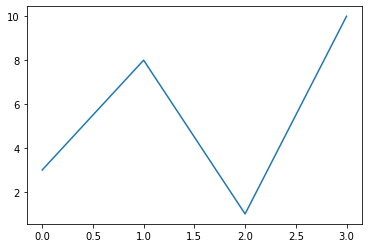

In [7]:
import matplotlib.pyplot as plt
import numpy as np

ypoints = np.array([3, 8, 1, 10])

plt.plot(ypoints, marker = '')
plt.show()

[[0.         0.        ]
 [0.06245697 0.121174  ]
 [0.1273109  0.23969605]
 [0.19445979 0.35541314]
 [0.26380165 0.46817228]
 [0.33523447 0.57782047]
 [0.40865626 0.68420471]
 [0.48396501 0.78717201]
 [0.56105874 0.88656937]
 [0.63983544 0.98224379]
 [0.72019312 1.07404228]
 [0.80202977 1.16181183]
 [0.88524339 1.24539945]
 [0.969732   1.32465214]
 [1.05539359 1.39941691]
 [1.14212615 1.46954075]
 [1.22982771 1.53487067]
 [1.31839625 1.59525368]
 [1.40772977 1.65053677]
 [1.49772629 1.70056694]
 [1.58828379 1.7451912 ]
 [1.67930029 1.78425656]
 [1.77067378 1.81761001]
 [1.86230227 1.84509856]
 [1.95408376 1.8665692 ]
 [2.04591624 1.88186895]
 [2.13769773 1.8908448 ]
 [2.22932622 1.89334376]
 [2.32069971 1.88921283]
 [2.41171621 1.87829901]
 [2.50227371 1.8604493 ]
 [2.59227023 1.83551071]
 [2.68160375 1.80333025]
 [2.77017229 1.7637549 ]
 [2.85787385 1.71663168]
 [2.94460641 1.66180758]
 [3.030268   1.59912961]
 [3.11475661 1.52844478]
 [3.19797023 1.44960008]
 [3.27980688 1.36244252]


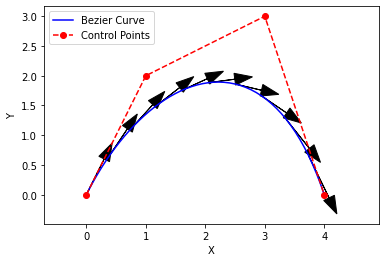

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

def bernstein_poly(i, n, t):
    """计算伯恩斯坦多项式的值"""
    return comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

def bezier_curve(control_points, num_points=50):
    """计算贝塞尔曲线上的点"""
    n = len(control_points) - 1
    t_values = np.linspace(0, 1, num_points)
    curve_points = np.zeros((num_points, 2))
    for t_index, t in enumerate(t_values): # 采样个数
        point = np.zeros(2)
        for i in range(n + 1): # 计算n+1次
            bernstein = bernstein_poly(i, n, t)
            point += bernstein * np.array(control_points[i])
        curve_points[t_index] = point
    return curve_points, t_values

def bezier_derivative(control_points):
    """计算贝塞尔曲线的一阶导数控制点"""
    n = len(control_points) - 1
    derivative = [n * (np.array(control_points[i + 1]) - np.array(control_points[i])) for i in range(n)]
    return derivative

def bezier_curve_derivative(control_points, t_values):
    """计算贝塞尔曲线的一阶导数点"""
    derivative_points = bezier_derivative(control_points)
    n = len(derivative_points) - 1
    curve_derivative = np.zeros((len(t_values), 2))
    for t_index, t in enumerate(t_values):
        point = np.zeros(2)
        for i, dp in enumerate(derivative_points):
            bernstein = bernstein_poly(i, n, t)
            point += dp * bernstein
        curve_derivative[t_index] = point
    return curve_derivative

# 控制点
control_points = [(0, 0), (1, 2), (3, 3), (4, 0)]
# 计算曲线点和 t 值
curve_points, t_values = bezier_curve(control_points, 50)
# 计算速度向量
velocity_vectors = bezier_curve_derivative(control_points, t_values)
# actual_velocities = velocity_vectors / time_interval
print(curve_points)
print("*"*100)
print(velocity_vectors)

# print(actual_velocities)

# 可视化
fig, ax = plt.subplots()
ax.plot(curve_points[:, 0], curve_points[:, 1], 'b-', label='Bezier Curve')
ax.plot([p[0] for p in control_points], [p[1] for p in control_points], 'ro--', label='Control Points')

# 绘制速度向量
for i in range(0, len(curve_points), 5):  # 每隔几个点绘制一个速度向量
    ax.arrow(curve_points[i, 0], curve_points[i, 1], 
             velocity_vectors[i, 0] * 0.1, velocity_vectors[i, 1] * 0.1, 
             head_width=0.2, head_length=0.3, fc='k', ec='k')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.axis('equal')
plt.show()


In [169]:
from scipy.special import comb
'''
    - 有了【n个贝塞尔控制点】,可以采样得到贝塞尔曲线 （1s走过的曲线）
    - 可以求一阶导得到【n-1个导数贝塞尔控制点】，采样得到速度贝塞尔曲线 （1s走过的曲线所对应的速度）

    - n阶贝塞尔曲线有n+1个控制点
    - control_points：阶数n_order,控制点数 n_order+1
    - derivative_points: 阶数 n_oder-1,控制点数 n_order
    - 每个采样点的得到都是对n+1个控制点的贝恩加权得到
'''

def bernstein_poly(i, n, t):
    """计算伯恩斯坦多项式的值"""
    return torch.tensor(comb(n, i) * (t ** i) * ((1 - t) ** (n - i))).cuda()

def bezier_derivative(control_points):
    """计算贝塞尔曲线的一阶导数控制点"""
    # control_points   B,3,(n_order+1), 2
    n = control_points.shape[2] - 1 # n阶贝塞尔曲线
    derivative = [n * (control_points[:,:,i + 1] - control_points[:,:,i]) for i in range(n)] # n个[B,3,2]
    return torch.stack(derivative, dim=2)

def bezier_derivative(control_points):
    """
    计算贝塞尔曲线的一阶导数控制点
    input:
        - control_points   B,3,(n_order+1), 2
        - control_points   B,N,3m,(n_order+1), 2
    output:
        - derivative_points: B,3,n_order, 2
        - derivative_points   B,N,3m,n_order, 2
    """
    squeeze_flag = False
    if len(control_points.shape) == 4:
        squeeze_flag = True
        control_points = control_points.unsqueeze(1) # B,1,3,n+1,2
    n = control_points.shape[-2] - 1 # n阶贝塞尔曲线
    derivative = [n * (control_points[:,:,:,i + 1] - control_points[:,:,:,i]) for i in range(n)] # n个[B,N,M,2]
    derivative = torch.stack(derivative, dim=-2) # B,N,3m,n,2
    if squeeze_flag:
        derivative = derivative.squeeze(1) # B,3,n,2
    return derivative

def bezier_curve(control_points, t_values):
    '''
    input:
        - control_points   B,3,(n_order+1), 2
        - control_points   B,N,3m,(n_order+1), 2
    return: 
        - curve_points  B,3,50, 2
        - curve_points  B,N,3m,50, 2
    '''
    squeeze_flag = False
    if len(control_points.shape) == 4:
        squeeze_flag = True
        control_points = control_points.unsqueeze(1) # B,1,3,n+1,2
    B,N,M,n,_ = control_points.shape
    n -= 1 # n代表贝塞尔曲线的阶数
    curve_points = []
    for t_index, t in enumerate(t_values): # 采样个数
        point = torch.zeros(B,N,M,2).cuda()
        for i in range(n + 1): # 计算n+1次
            bernstein = bernstein_poly(i, n, t)
            point += bernstein * control_points[:,:,:,i,:] # B,N,M,2
        curve_points.append(point)
    curve_points = torch.stack(curve_points, dim=-2) # B,N,M,50,2
    if squeeze_flag:
        curve_points = curve_points.squeeze(1) # B,M,50,2
    return curve_points

(2, 3, 8, 2)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


(2, 3, 50, 2) (2, 3, 8, 2)


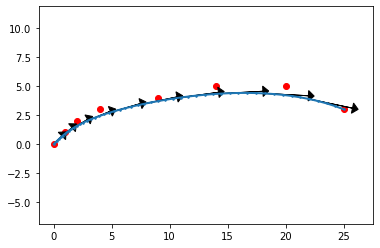

In [177]:
# 生成固定控制点序列 2,3,8,2
control_points = np.array([
        [
            [[0, 0], [1, 1], [2, 2], [4, 3], [9, 4], [14, 5], [20, 5], [25, 3]],  # 第一条轨迹
            [[0, 1], [1, 3], [2, 5], [3, 7], [4, 9], [5, 11], [6, 13], [7, 15]],  # 第二条轨迹
            [[0, 2], [1, 4], [2, 6], [3, 8], [4, 10], [5, 12], [6, 14], [7, 16]]  # 第三条轨迹
        ],
        [
            [[1, 0], [2, 1], [3, 2], [4, 3], [5, 4], [6, 5], [7, 6], [8, 7]],  # 第一条轨迹
            [[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8]],  # 第二条轨迹
            [[1, 2], [2, 3], [3, 4], [3.5, 5], [3, 6], [2, 7], [1, 8], [0, 9]]  # 第三条轨迹
        ]
    ])
print(control_points.shape)
control_points = torch.from_numpy(control_points).cuda() # 2,3,8,2
t_values = torch.linspace(0,1,50).cuda()
curve_points= bezier_curve(control_points, t_values) # b,3,50,2
der_control_points = bezier_derivative(control_points)
der_curv_points= bezier_curve(der_control_points, t_values) # b,3,50,2





# vis
curve_points = curve_points.cpu().numpy()
control_points = control_points.cpu().numpy()
der_curv_points = der_curv_points.cpu().numpy()
ct_ps= control_points[0,0,:] # 8,2
cr_ps = curve_points[0,0,:] # 50,2
dc_ps = der_curv_points[0,0,:] # 50,2
print(curve_points.shape,control_points.shape)

# 打印控制点
fig, ax = plt.subplots()
ax.scatter(ct_ps[:,0],ct_ps[:,1],c='red')

# 轨迹点
ax.plot(cr_ps[:,0],cr_ps[:,1],marker='.',linewidth = '2',ms=3) # 50,2

# 绘制速度向量
for i in range(0, len(cr_ps), 5):  # 每隔几个点绘制一个速度向量
    ax.arrow(cr_ps[i, 0], cr_ps[i, 1], 
             dc_ps[i, 0] * 0.1, dc_ps[i, 1] * 0.1, 
             head_width=0.9, head_length=0.5, fc='k', ec='k')


ax.axis('equal')
plt.show()

In [ ]:
t_values = torch.linspace(0,1,50)
control_points = torch

[2 3 3 3 2 2 3 1 2 1 3 1 3 3 2 3 1 2 2 1 1 1 1 3 3 2 1 2 2 1]


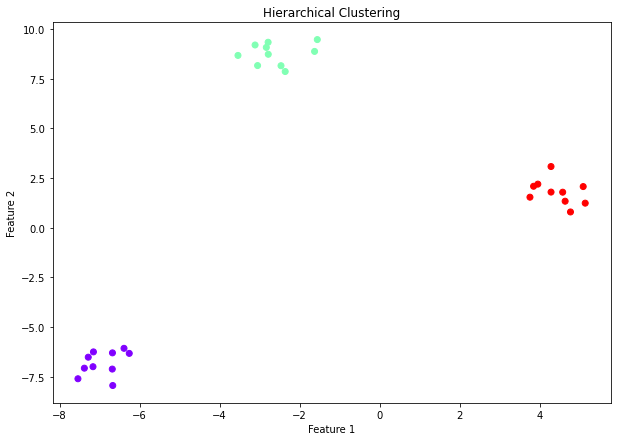

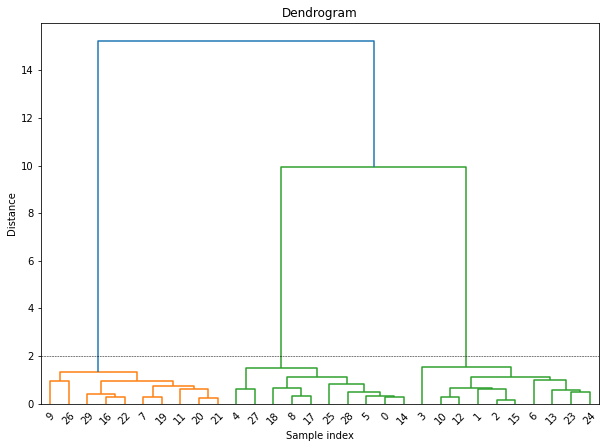

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

# 生成示例数据
X, _ = make_blobs(n_samples=30, centers=3, cluster_std=0.60, random_state=42)

# 计算距离矩阵
distance_matrix = pdist(X, metric='euclidean')

# 使用 linkage 计算层次聚类
Z = linkage(distance_matrix, method='average')

# 使用 fcluster 从层次树中提取簇
max_d = 2  # 设置距离阈值
clusters = fcluster(Z, max_d, criterion='distance')
print(clusters)
# 绘制聚类结果
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='rainbow')
plt.title('Hierarchical Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# 绘制聚类层次树（dendrogram）
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.axhline(y=max_d, c='k', ls='--', lw=0.5)
plt.show()


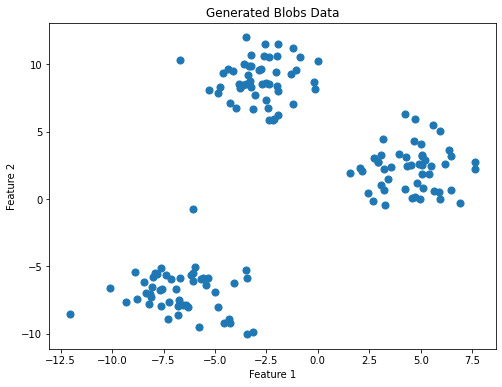

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# 生成模拟数据
X, _ = make_blobs(n_samples=150, centers=3, cluster_std=1.60, random_state=42)

# 绘制数据点
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis')
plt.title('Generated Blobs Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
